In [2]:
# Electricity Load Forecasting - Exploratory Data Analysis (EDA)

# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the Excel file
file_path = "../data/train_dataframes.xlsx"  # Change this to your file path
xls = pd.ExcelFile(file_path)

# Load a subset of sheets (first 5) for efficient analysis
selected_sheets = xls.sheet_names[:5]
df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in selected_sheets]
df = pd.concat(df_list, ignore_index=True)

# Convert datetime column to proper format
df["datetime"] = pd.to_datetime(df["datetime"])

# Display first few rows
df.head()


,datetime,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
0,2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
1,2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2,2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
3,2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
4,2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472


In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load the dataset
file_path = "../data/train_dataframes.xlsx"  # Change this path
xls = pd.ExcelFile(file_path)

# Load selected sheets (first 5 to optimize performance)
selected_sheets = xls.sheet_names[:5]
df_list = [pd.read_excel(xls, sheet_name=sheet) for sheet in selected_sheets]
df = pd.concat(df_list, ignore_index=True)

# Convert datetime column to datetime type
df["datetime"] = pd.to_datetime(df["datetime"])
df.set_index("datetime", inplace=True)

# Display basic info
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 191496 entries, 2015-01-31 01:00:00 to 2019-08-14 00:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   week_X-2    191496 non-null  float64
 1   week_X-3    191496 non-null  float64
 2   week_X-4    191496 non-null  float64
 3   MA_X-4      191496 non-null  float64
 4   dayOfWeek   191496 non-null  int64  
 5   weekend     191496 non-null  int64  
 6   holiday     191496 non-null  int64  
 7   Holiday_ID  191496 non-null  int64  
 8   hourOfDay   191496 non-null  int64  
 9   T2M_toc     191496 non-null  float64
 10  DEMAND      191496 non-null  float64
dtypes: float64(6), int64(5)
memory usage: 17.5 MB


,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,DEMAND
datetime,,,,,,,,,,,
2015-01-31 01:00:00,962.2865,906.9580,970.3450,938.004850,1,1,0,0,1,25.308496,954.2018
2015-01-31 02:00:00,933.3221,863.5135,912.1755,900.284075,1,1,0,0,2,25.141443,913.8660
2015-01-31 03:00:00,903.9817,848.4447,900.2688,881.704325,1,1,0,0,3,25.006738,903.3637
2015-01-31 04:00:00,900.9995,839.8821,889.9538,876.458825,1,1,0,0,4,24.899713,889.0806
2015-01-31 05:00:00,904.3481,847.1073,893.6865,879.190775,1,1,0,0,5,24.821558,910.1472


In [4]:
# Create lag features (important lags based on ACF/PACF)
for lag in [1, 7, 14, 21, 28]:
    df[f"lag_{lag}"] = df["DEMAND"].shift(lag)

# Create rolling statistics (3-day, 7-day, 14-day moving averages)
df["rolling_mean_3"] = df["DEMAND"].rolling(window=3, min_periods=1).mean()
df["rolling_mean_7"] = df["DEMAND"].rolling(window=7, min_periods=1).mean()
df["rolling_mean_14"] = df["DEMAND"].rolling(window=14, min_periods=1).mean()

# Optionally: create rolling std deviation (helps in volatile demand)
df["rolling_std_7"] = df["DEMAND"].rolling(window=7, min_periods=1).std()

# Time-based features
df["hour"] = df.index.hour
df["dayofweek"] = df.index.dayofweek
df["month"] = df.index.month
df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)  # New feature

# Drop NaN values generated by lagging
df.dropna(inplace=True)

# Display updated data
df.head()


,week_X-2,week_X-3,week_X-4,MA_X-4,dayOfWeek,weekend,holiday,Holiday_ID,hourOfDay,T2M_toc,...,lag_21,lag_28,rolling_mean_3,rolling_mean_7,rolling_mean_14,rolling_std_7,hour,dayofweek,month,is_weekend
datetime,,,,,,,,,,,,,,,,,,,,,
2015-02-01 05:00:00,815.4005,842.7522,884.6659,834.463400,2,1,0,0,5,25.043604,...,1077.8575,954.2018,859.554733,899.297300,990.348871,49.740936,5,6,2,1
2015-02-01 06:00:00,785.2751,807.4211,862.9888,810.501925,2,1,0,0,6,25.096826,...,1179.6601,913.8660,842.977867,875.539257,971.814971,38.422319,6,6,2,1
2015-02-01 07:00:00,784.1150,813.1819,871.6873,815.810325,2,1,0,0,7,26.019800,...,1255.1569,903.3637,836.889000,861.114386,955.650414,27.911603,7,6,2,1
2015-02-01 08:00:00,850.1076,873.8010,912.4966,867.222075,2,1,0,0,8,27.205042,...,1253.4414,889.0806,853.417633,860.408843,941.640557,26.670768,8,6,2,1
2015-02-01 09:00:00,900.5203,935.3192,969.8017,925.125075,2,1,0,0,9,28.295648,...,1223.6116,910.1472,901.311667,872.123600,930.875036,48.117779,9,6,2,1


In [5]:
import pandas as pd

# Load your train and test datasets
train_df = df.copy()  # Assuming your feature-engineered training df is already named df
test_df = pd.read_excel("../data/test_dataframes.xlsx")

# Ensure datetime is correctly set
if "datetime" in test_df.columns:
    test_df["datetime"] = pd.to_datetime(test_df["datetime"])
    test_df.set_index("datetime", inplace=True)

# -------------------------
# Feature Engineering - Must be SAME for both train and test
# -------------------------

# Lags
for lag in [1, 7, 14, 21, 28]:
    train_df[f"lag_{lag}"] = train_df["DEMAND"].shift(lag)
    test_df[f"lag_{lag}"] = test_df["DEMAND"].shift(lag)

# Rolling means and std
for window in [3, 7, 14]:
    train_df[f"rolling_mean_{window}"] = train_df["DEMAND"].rolling(window=window).mean()
    test_df[f"rolling_mean_{window}"] = test_df["DEMAND"].rolling(window=window).mean()

train_df["rolling_std_7"] = train_df["DEMAND"].rolling(window=7).std()
test_df["rolling_std_7"] = test_df["DEMAND"].rolling(window=7).std()

# Time-based features
for df_ in [train_df, test_df]:
    df_["hour"] = df_.index.hour
    df_["dayofweek"] = df_.index.dayofweek
    df_["month"] = df_.index.month
    df_["is_weekend"] = df_.index.dayofweek.isin([5, 6]).astype(int)

# -------------------------
# Drop NaNs generated by rolling/lags
# -------------------------
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# -------------------------
# Create X_train, y_train, and X_test
# -------------------------
TARGET = "DEMAND"

features = [col for col in train_df.columns if col != TARGET]

X_train = train_df[features]
y_train = train_df[TARGET]

X_test = test_df[features]  # Same features as training
y_test = test_df['DEMAND']

# Confirm shape
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")



X_train shape: (191440, 23)
y_train shape: (191440,)
X_test shape: (140, 23)


In [6]:
# ======== 1. Imports ========
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ======== 2. Preprocessing ========

# Example: Assume you already have your train and test data
# y_train, y_test must be defined already
# Replace this with your actual DataFrame loading code if needed.

# Define time steps for sliding window
time_steps = 60

# Sliding window dataset creation
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

# Scale the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# Prepare sliding window datasets
X_train, y_train_final = create_dataset(y_train_scaled, time_steps)
X_test, y_test_final = create_dataset(y_test_scaled, time_steps)

# Reshape inputs for LSTM/Transformer (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# ======== 3. Model Definition (Simplified TFT) ========

class SimplifiedTFT(Model):
    def __init__(self, time_steps, num_features, output_size):
        super(SimplifiedTFT, self).__init__()

        # Feature selection layer
        self.feature_selection = Dense(num_features, activation='softmax')

        # LSTM Encoder
        self.encoder_lstm = LSTM(64, return_sequences=True)

        # LSTM Decoder
        self.decoder_lstm = LSTM(64, return_sequences=True)

        # Multi-Head Attention
        self.attention = keras.layers.MultiHeadAttention(num_heads=4, key_dim=64)

        # Layer Normalization
        self.layer_norm = LayerNormalization()

        # Final dense layer
        self.final_dense = Dense(output_size)

    def call(self, inputs):
        # Feature selection
        feature_weights = self.feature_selection(tf.reduce_mean(inputs, axis=1))
        feature_weights = tf.expand_dims(feature_weights, axis=1)
        selected_inputs = inputs * feature_weights

        # Encoder
        encoder_output = self.encoder_lstm(selected_inputs)

        # Decoder
        decoder_output = self.decoder_lstm(encoder_output)

        # Attention mechanism
        attn_output = self.attention(decoder_output, decoder_output)

        # Residual connection + Layer Normalization
        output = self.layer_norm(attn_output + decoder_output)

        # Final prediction (take last time step output)
        final_output = self.final_dense(output[:, -1, :])

        return final_output

# Instantiate the model
model = SimplifiedTFT(time_steps=time_steps, num_features=1, output_size=1)

# Compile
model.compile(optimizer='adam', loss='mean_squared_error')

# ======== 4. Training ========

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train_final,
    epochs=2,
    batch_size=32,
    validation_data=(X_test, y_test_final),
    callbacks=[early_stopping],
    verbose=1
)


Epoch 1/2


/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (None, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


5981/5981 ━━━━━━━━━━━━━━━━━━━━ 388s 60ms/step - loss: 0.0240 - val_loss: 5.3313e-04
Epoch 2/2
5981/5981 ━━━━━━━━━━━━━━━━━━━━ 279s 47ms/step - loss: 7.4252e-04 - val_loss: 5.0350e-04


/opt/anaconda3/lib/python3.11/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis -1 of a tensor of shape (32, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 199ms/step
TFT - Mean Absolute Error (MAE): 28.77
TFT - Root Mean Squared Error (RMSE): 36.66


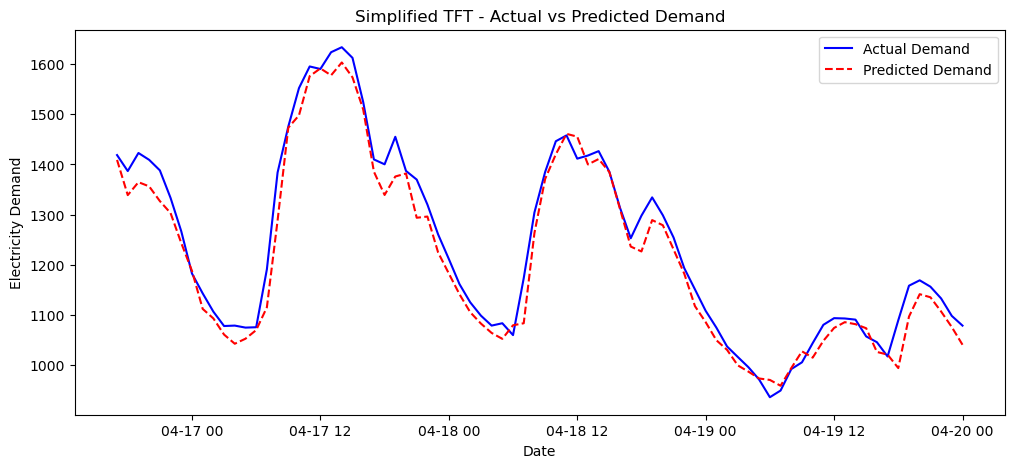

In [7]:
# ======== 5. Predictions and Inverse Scaling ========

# Predict
predicted = model.predict(X_test)

# Inverse transform to original scale
predicted = scaler.inverse_transform(predicted)
y_test_actual = scaler.inverse_transform(y_test_final.reshape(-1, 1))

# ======== 6. Evaluation ========

mae = mean_absolute_error(y_test_actual, predicted)
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted))

print(f"TFT - Mean Absolute Error (MAE): {mae:.2f}")
print(f"TFT - Root Mean Squared Error (RMSE): {rmse:.2f}")

# ======== 7. Plotting ========

plt.figure(figsize=(12, 5))
plt.plot(y_test.index[time_steps:], y_test_actual, label="Actual Demand", color="blue")
plt.plot(y_test.index[time_steps:], predicted, label="Predicted Demand", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Electricity Demand")
plt.title("Simplified TFT - Actual vs Predicted Demand")
plt.legend()
plt.show()

In [8]:
import os

# Create the folder if it doesn't exist
os.makedirs("../model_weights", exist_ok=True)

# Save the entire model (architecture + weights + optimizer)
model.save("../model_weights/simplified_tft_model.keras")

print("Simplified TFT model saved at '../model_weights/simplified_tft_model.keras'")


Simplified TFT model saved at '../model_weights/simplified_tft_model.keras'


In [9]:
import joblib

# Save the scaler used for preprocessing
joblib.dump(scaler, "../model_weights/simplified_tft_scaler.pkl")

print("Scaler saved at 'model_weights/simplified_tft_scaler.pkl'")


Scaler saved at 'model_weights/simplified_tft_scaler.pkl'
